In [1]:
import numpy as np
import makeData as mk
import gurobipy as gp
import matplotlib.pyplot as plt
import itertools 

mk.makeData (arquivo makeData.py) coloca uma instalação (ou várias) sobre um círculo, posiciona consumidores em uma malha retangular e devolve distâncias Manhattan dd[i,j] entre cada par instalação-cliente. Essas distâncias serão usadas como custo de transporte por unidade. 

In [2]:
I = 1          # número de instalações possíveis
J = 3          # número de clientes

dd,iPos,jPos = mk.makeData(I,J)
c  = 10.0 + np.arange(I)          # custo de instalar 1 unid. de capacidade
demand = [80,100,120]             # três níveis de demanda para CADA cliente
prob   = [0.25,0.5,0.25]          # probabilidades desses níveis

## Função Q(x,scenario,…) – sub-problema de 2ª fase

In [4]:
def Q(x,scenario,I,J,c,dd):
    gp.setParam('LogToConsole', 0)
    m = gp.Model()
    y = m.addVars(I,J,lb=0,name='y') # fluxos enviados
    s = m.addVars(J, lb=0, name='s') # slack variables
    con = m.addConstrs( y.sum(i,'*') <= x[i] for i in range(I)) # capacidade não pode ser excedida
    m.addConstrs( y.sum('*',j) + s[j] >= scenario[j] for j in range(J))     # cada cliente recebe todo o pedido ou paga falta
    
    # custo de segundo estágio
    obj = gp.quicksum(y[i,j]*dd[i,j] for i in range(I) for j in range(J)) + 100*s.sum('*')
    m.setObjective(obj, sense=gp.GRB.MINIMIZE)
    m.optimize()

    return obj.getValue(), np.array([con[i].Pi for i in range(I)])

$con[i].Pi$ – multiplicador de Lagrange (dual) da restrição de capacidade da instalação $i$. Esses multiplicadores formam um subgradiente de $Q(x,ω)$ em relação a $x$; é justamente o ingrediente necessário para formar os cortes de Benders ou, aqui, o gradiente da função de custo esperado.

## Função fg1 – custo e gradiente esperados

In [5]:
def fg1(x, I, J, c, dd, demand, prob):
    fval  = np.dot(c, x)          # custo fixo da 1ª fase
    grad  = np.array(c)           # derivada da parte fixa
    
    # enumerate all |Ω| = 3^J = 27 scenarios
    for scenario, probs in zip(
            itertools.product(*(J*[demand])),
            itertools.product(*(J*[prob])) ):

        v, s  = Q(x, scenario, I, J, c, dd)   # resolve subproblema
        pp    = np.array(probs).prod()        # P(ω) = ∏ P(d_j)
        
        fval += pp * v    # soma custo esperado
        grad += pp * s    # soma subgradiente esperado
        
    return fval, grad

In [8]:
fg = lambda x: fg1(x, I, J, c, dd, demand, prob)

xx = np.linspace(100, 800, 1000)
yy = [fg(np.array([x]))[0] for x in xx]   # valores de f(x)
gg = [fg(np.array([x]))[1] for x in xx]   # derivadas ∂f/∂x

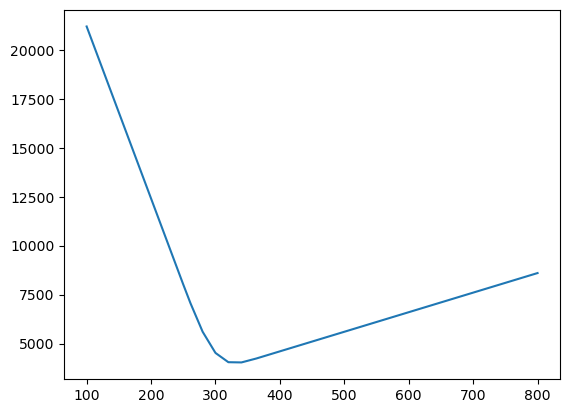

In [9]:
plt.plot(xx,yy)

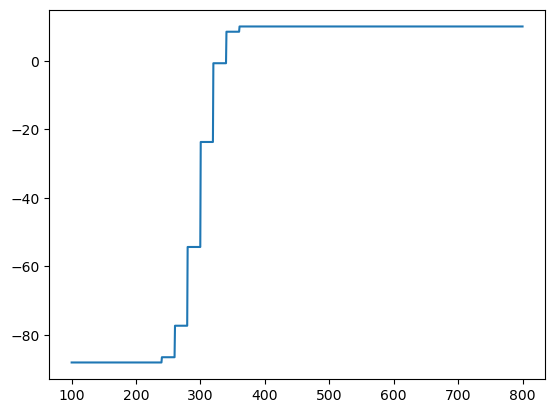

In [ ]:
plt.plot(xx,gg)

In [11]:
import pynso.cuttingPlane as cp

In [12]:
x0 = np.array([10])
res = cp.minimize(x0,fg=fg)

No models currently loaded
None
disposing


In [13]:
res

fval = 4030.6250000000005
nIter = 5
status = 0
time = 0.1340467929840088
optimalityMeasure = 0.0

In [14]:
res.x

array([340.])

### Soma dos índices pares e ímpares

In [3]:
I = 4                       # 4 instalações
J = 3                       # 3 clientes
dd, iPos, jPos = mk.makeData(I, J)
c  = 10.0 + np.arange(I)    # [10,11,12,13]
demand = [80, 100, 120]
prob   = [0.25, 0.5, 0.25]

even_idx = [i for i in range(I) if i % 2 == 0]   # [0,2]
odd_idx  = [i for i in range(I) if i % 2 == 1]   # [1,3]


In [8]:
def Q(x, scenario, I, J, dd):
    gp.setParam('LogToConsole', 0)
    m = gp.Model()

    # 2ª fase
    y = m.addVars(I, J, lb=0, name='y')
    s = m.addVars(J, lb=0, name='s')

    # grupos de instalações
    even_idx = [i for i in range(I) if i % 2 == 0]
    odd_idx  = [i for i in range(I) if i % 2 == 1]

    # capacidade agregada
    cap_even = float(x[even_idx].sum())
    cap_odd  = float(x[odd_idx].sum())

    con_even = m.addConstr(
        gp.quicksum(y[i, j] for i in even_idx for j in range(J)) <= cap_even,
        name="cap_even"
    )
    con_odd  = m.addConstr(
        gp.quicksum(y[i, j] for i in  odd_idx for j in range(J)) <= cap_odd,
        name="cap_odd"
    )

    # atender demanda ou pagar falta
    m.addConstrs(
        gp.quicksum(y[i, j] for i in range(I)) + s[j] >= scenario[j]
        for j in range(J)
    )

    # custo 2ª fase
    m.setObjective(
        gp.quicksum(y[i, j] * dd[i, j] for i in range(I) for j in range(J))
        + 100 * s.sum('*'),
        gp.GRB.MINIMIZE
    )
    m.optimize()

    # ----- duals → subgradiente de Q em relação a x -----
    lam_even = con_even.Pi
    lam_odd  = con_odd.Pi
    grad = np.zeros(I)
    grad[even_idx] = lam_even
    grad[odd_idx]  = lam_odd

    return m.ObjVal, grad         


In [9]:
def fg1(x, I, J, c, dd, demand, prob):
    fval = np.dot(c, x)           # custo fixo
    grad = np.array(c)     # parte fixa do gradiente

    # gera todos os 3^J = 27 cenários
    for scen, probs in zip(itertools.product(*(J*[demand])),
                           itertools.product(*(J*[prob]))):
        v, subgrad = Q(x, np.array(scen), I, J, dd)
        q = np.prod(probs)   # probabilidade do cenário
        fval += q * v
        grad += q * subgrad
    return fval, grad


In [10]:
x0

array([10, 10, 10, 10])

In [11]:
fg = lambda x: fg1(x, I, J, c, dd, demand, prob)

import pynso.cuttingPlane as cp
x0  = np.full(I, 10)        # chute inicial (300 u cada)
res = cp.minimize(x0, fg=fg)

print("capacidade ótima x* =", res.x)
print("custo esperado f(x*) =", res.fval)


No models currently loaded
None
disposing
capacidade ótima x* = [10000.         10000.         -9897.93455164 -9782.06544836]
custo esperado f(x*) = -34468.0
